<a href="https://colab.research.google.com/github/radanim/TIL/blob/master/Super_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteYQI630/div2k-train.tfrecord*...:   0%|       …

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteYQI630/div2k-validation.tfrecord*...:   0%|  …

Dataset div2k downloaded and prepared to ~/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


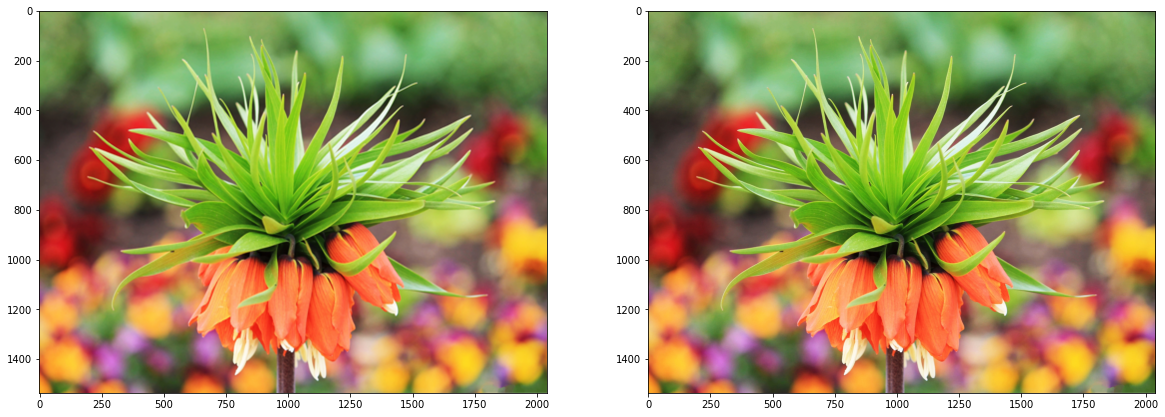

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# 데이터를 불러옵니다.
train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

# 시각화를 위해 한 개의 데이터만 선택합니다.
for i, (lr, hr) in enumerate(valid):
    if i == 3: break
    
# 저해상도 이미지를 고해상도 이미지 크기로 bicubic interpolation 합니다.  
hr, lr = np.array(hr), np.array(lr)
bicubic_hr = cv2.resize(
    lr, 
    dsize=(hr.shape[1], hr.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

# 저해상도 및 고해상도 이미지를 시각화합니다.
plt.figure(figsize=(20,10))
plt.subplot(1,2,1); plt.imshow(bicubic_hr)
plt.subplot(1,2,2); plt.imshow(hr)


Text(0.5, 1.0, 'HR')

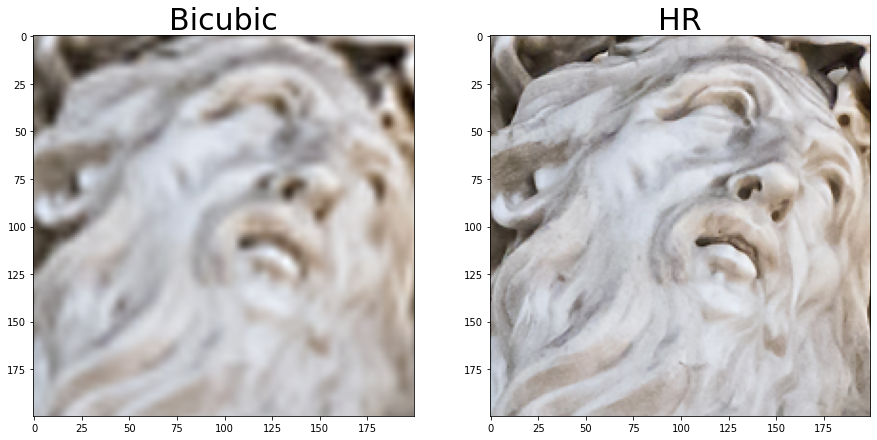

In [ ]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# interpolation된 이미지와 고해상도 이미지의 동일한 부분을 각각 잘라냅니다.
left_top = (400, 500)
crop_bicubic_hr = crop(bicubic_hr, left_top)
crop_hr = crop(hr, left_top)

# 잘라낸 부분을 시각화 합니다.
plt.figure(figsize=(15,25))
plt.subplot(1,2,1); plt.imshow(crop_bicubic_hr); plt.title("Bicubic", fontsize=30)
plt.subplot(1,2,2); plt.imshow(crop_hr); plt.title("HR", fontsize=30)

In [ ]:
import tensorflow as tf

def preprocessing(lr, hr):
    # 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr = tf.image.random_crop(hr, size=[96, 96, 3])
    hr = tf.cast(hr, tf.float32) / 255.
    
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄였다가
    # interpolation을 이용해 다시 원래 크기로 되돌립니다.
    # 이렇게 만든 저해상도 이미지를 입력으로 사용합니다.
    lr = tf.image.resize(hr, [96//4, 96//4], "bicubic")
    lr = tf.image.resize(lr, [96, 96], "bicubic")
    return lr, hr

train = train.map(preprocessing).shuffle(buffer_size=10).batch(16)
valid = valid.map(preprocessing).batch(16)

In [ ]:
from tensorflow.keras import layers, Sequential

# 3개의 convolutional layer를 갖는 Sequential 모델을 구성합니다.
srcnn = Sequential()
# 9x9 크기의 필터를 128개 사용합니다.
srcnn.add(layers.Conv2D(128, 9, padding="same", input_shape=(None, None, 3)))
srcnn.add(layers.ReLU())
# 5x5 크기의 필터를 64개 사용합니다.
srcnn.add(layers.Conv2D(64, 5, padding="same"))
srcnn.add(layers.ReLU())
# 5x5 크기의 필터를 64개 사용합니다.
srcnn.add(layers.Conv2D(3, 5, padding="same"))

srcnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 128)   31232     
                                                                 
 re_lu (ReLU)                (None, None, None, 128)   0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    204864    
                                                                 
 re_lu_1 (ReLU)              (None, None, None, 64)    0         
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 3)     4803      
                                                                 
Total params: 240,899
Trainable params: 240,899
Non-trainable params: 0
_________________________________________________________________


In [ ]:
srcnn.compile(
    optimizer="adam", 
    loss="mse"
)

srcnn.fit(train, validation_data=valid, epochs=100)

Epoch 1/100
50/50 [==============================] - 60s 1s/step - loss: 0.0375 - val_loss: 0.0063
Epoch 2/100
50/50 [==============================] - 61s 1s/step - loss: 0.0048 - val_loss: 0.0034
Epoch 3/100
50/50 [==============================] - 59s 1s/step - loss: 0.0045 - val_loss: 0.0046
Epoch 4/100
50/50 [==============================] - 58s 1s/step - loss: 0.0043 - val_loss: 0.0041
Epoch 5/100
50/50 [==============================] - 59s 1s/step - loss: 0.0044 - val_loss: 0.0048
Epoch 6/100
50/50 [==============================] - 60s 1s/step - loss: 0.0047 - val_loss: 0.0044
Epoch 7/100
50/50 [==============================] - 59s 1s/step - loss: 0.0044 - val_loss: 0.0041
Epoch 8/100
50/50 [==============================] - 58s 1s/step - loss: 0.0043 - val_loss: 0.0036
Epoch 9/100
50/50 [==============================] - 60s 1s/step - loss: 0.0043 - val_loss: 0.0045
Epoch 10/100
50/50 [==============================] - 59s 1s/step - loss: 0.0041 - val_loss: 0.0048
Epoch 11/

In [ ]:
def apply_srcnn(image):
    sr = srcnn.predict(image[np.newaxis, ...]/255.)
    sr[sr > 1] = 1
    sr[sr < 0] = 0
    sr *= 255.
    return np.array(sr[0].astype(np.uint8))

srcnn_hr = apply_srcnn(bicubic_hr)

1/1 [==============================] - 1s 622ms/step


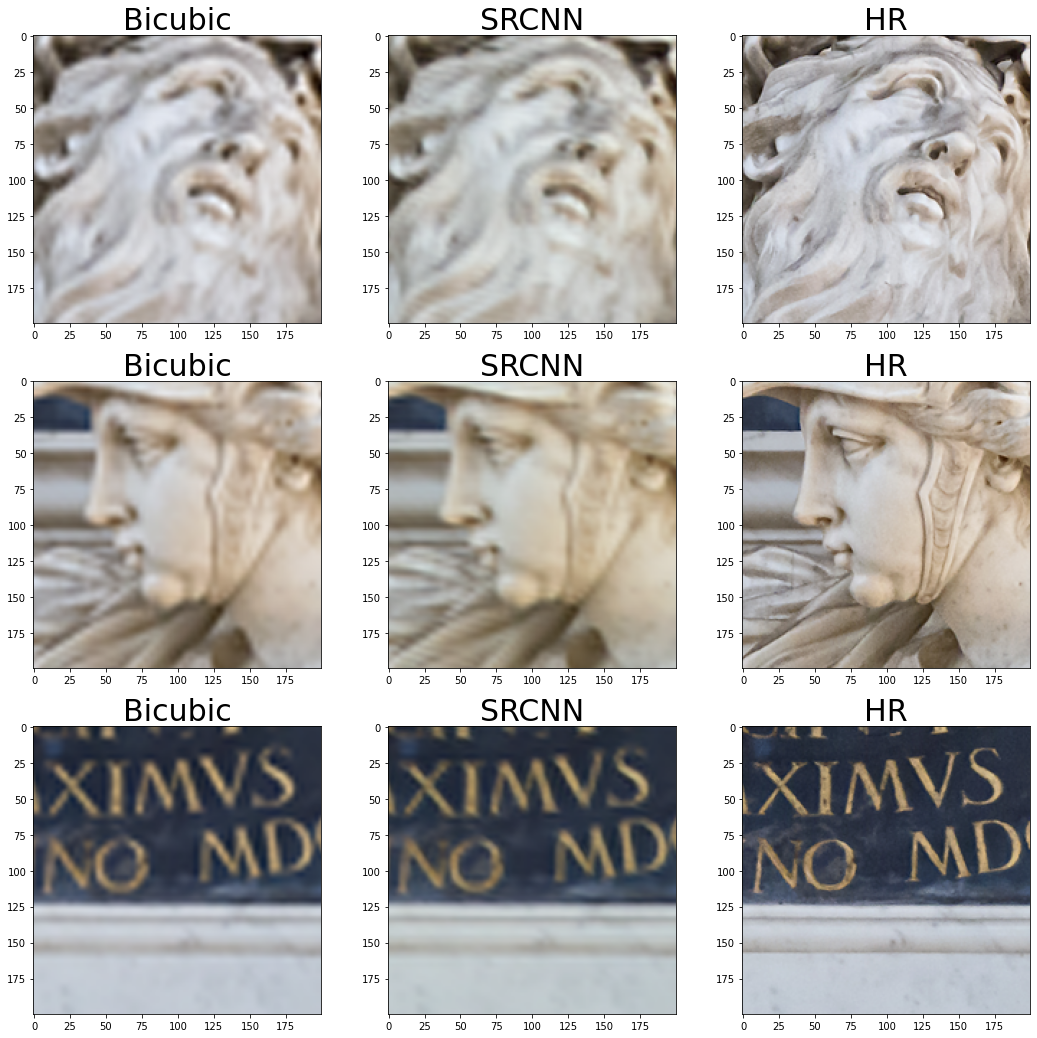

In [ ]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(400,500), (300,1200), (0,1000)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srcnn_hr , left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRCNN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)